In [97]:
from pathlib import Path
from Bio.PDB import PDBList, PDBParser
import os
from tqdm import tqdm
import warnings
import pandas as pd
from Bio import SeqIO
from dotenv import load_dotenv
import os
import requests
import time
import json
from Bio.PDB.ic_rebuild import structure_rebuild_test
import numpy as np
import sys
import seaborn as sns
from Bio.Align import PairwiseAligner
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
from sklearn.linear_model import LinearRegression

load_dotenv()
amino_acid_codes = json.load(open('amino_acid_codes.json'))

In [105]:
WINDOW_SIZE = 5
WINDOW_SIZE_CONTEXT = 6
PDBMINE_URL = os.getenv("PDBMINE_URL")
casp_protein_id = 'T1030'; pdb_code = '6poo'
# casp_protein_id = 'T1024'; pdb_code = '6t1z'
# casp_protein_id = 'T1028'; pdb_code = '6vqp'
# casp_protein_id = 'T1038'; pdb_code = '6ya2'

alphafold_id = f'{casp_protein_id}TS427_1'
outdir = Path(f'tests/{casp_protein_id}_win{WINDOW_SIZE}-{WINDOW_SIZE_CONTEXT}')
if outdir.exists():
    print('Results already exist')
else:
    outdir.mkdir(exist_ok=False, parents=True)

Results already exist


In [106]:
def get_center(seq):
    if WINDOW_SIZE % 2 == 0:
        return seq[WINDOW_SIZE // 2 - 1]
    else:
        return seq[-WINDOW_SIZE // 2]
def get_seq(i):
    if WINDOW_SIZE % 2 == 0:
        if WINDOW_SIZE_CONTEXT % 2 == 0:
            return slice(i-WINDOW_SIZE//2+1,i+WINDOW_SIZE//2+1)
        return slice(i-WINDOW_SIZE//2,i+WINDOW_SIZE//2)
    else:
        return slice(i-WINDOW_SIZE//2,i+WINDOW_SIZE//2+1)
def get_seq_ctxt(i):
    if WINDOW_SIZE_CONTEXT % 2 == 0:
        return slice(i-WINDOW_SIZE_CONTEXT//2+1,i+WINDOW_SIZE_CONTEXT//2+1)
    return slice(i-WINDOW_SIZE_CONTEXT//2,i+WINDOW_SIZE_CONTEXT//2+1)
def get_subseq(seq):
    if WINDOW_SIZE % 2 == 0:
        return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2]
    else:
        if WINDOW_SIZE_CONTEXT % 2 == 0:
            return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2-1:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2]
        return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2 + 1]

In [107]:
# Get X-ray pdb
pdbl = PDBList()
parser = PDBParser()
xray_fn = pdbl.retrieve_pdb_file(pdb_code, pdir='pdb', file_format='pdb', obsolete=False)

# Get CASP predictions
predictions_url = f'https://predictioncenter.org/download_area/CASP14/predictions/regular/{casp_protein_id}.tar.gz'
predictions_dir = Path(f'./casp-predictions/')
if not (predictions_dir / casp_protein_id).exists():
    predictions_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {predictions_dir}/{casp_protein_id}.tar.gz {predictions_url}')
    os.system(f'tar -xvf {predictions_dir}/{casp_protein_id}.tar.gz -C {predictions_dir}')

# Get CASP results
results_url = 'https://predictioncenter.org/download_area/CASP14/results/tables/casp14.res_tables.T.tar.gz'
results_dir = Path('casp-results')
if not results_dir.exists():
    results_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {results_dir / "casp14.res_tables.T.tar.gz"} {results_url}')
    os.system(f'tar -xvf {results_dir / "casp14.res_tables.T.tar.gz"} -C {results_dir}')
results_file = results_dir / f'{casp_protein_id}.txt'
if not results_file.exists():
    results_file = Path(results_dir / f'{casp_protein_id}-D1.txt')
results = pd.read_csv(results_file, sep='\s+')
results = results[results.columns[1:]]
results['Model'] = results['Model'].apply(lambda x: x.split('-')[0])

Structure exists: 'pdb/pdb6poo.ent' 


In [108]:
# Check alignment of casp prediction and x-ray structure
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    record = next(iter(SeqIO.parse(xray_fn, "pdb-seqres")))
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    # print(record.seq)
    print(len(record.seq))
    residue_chain = str(record.seq)#[residue_range[0]-1:residue_range[1]]
    print(residue_chain)

    pred_files = list((predictions_dir / casp_protein_id).iterdir())
    i=0
    print(pred_files[i].name)
    pred_seq = str(next(iter(SeqIO.parse(pred_files[i], "pdb-atom"))).seq)
    print(pred_seq)

    aligner = PairwiseAligner()
    aligner.mode = 'global'
    alignments =  aligner.align(residue_chain, pred_seq)

    print(alignments[0])
    print('Large matches:')
    for i,((t1,t2),(q1,q2)) in enumerate(zip(*alignments[0].aligned)):
        if t2-t1 > 5:
            print(f'Match of length: {t2-t1} residues at position t={t1}, q={q1}')

Record id 6POO:A, chain A
273
DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKAKQMAQNDVALIKNISPEVLEEYKEKIQRASTKSQVDEFVAEAKKVVNSNKETLVNQANGKKQEIAKLENLSNDEMLRYNTAIDNVVKQYNEGKLNITAAMNALNSIKQAAQEVAQKNLQKQYAKKIERISSKGLALSKKAKEIYEKHKSILPTPGYYADSVGTYLNRFRDKQTFGNRSVWTGQSGLDEAKKMLDEVKKLLKELQDLTRGTKED
T1030TS392_3
DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKAKQMAQNDVALIKNISPEVLEEYKEKIQRASTKSQVDEFVAEAKKVVNSNKETLVNQANGKKQEIAKLENLSNDEMLRYNTAIDNVVKQYNEGKLNITAAMNALNSIKQAAQEVAQKNLQKQYAKKIERISSKGLALSKKAKEIYEKHKSILPTPGYYADSVGTYLNRFRDKQTFGNRSVWTGQSGLDEAKKMLDEVKKLLKELQDLTRGTKED
target            0 DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKA
                  0 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
query             0 DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKA

target           60 KQMAQNDVALIKNISPEVLEEYKEKIQRASTKSQVDEFVAEAKKVVNSNKETLVNQANGK
                 60 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
que

# Collect Dihedrals - Xray and predictions

In [185]:
xray_structure = parser.get_structure(pdb_code, xray_fn)
xray_chain = list(xray_structure[0].get_chains())[0]

def get_phi_psi_for_structure(protein_structure, protein_id):
    protein_structure.atom_to_internal_coordinates(verbose=False)
    resultDict = structure_rebuild_test(protein_structure)
    if not resultDict['pass']:
        raise Exception('Failed to rebuild')
    residues = list(protein_structure.get_residues())
    phi_psi_ = []
    print([r.resname for r in residues])
    for i in range(WINDOW_SIZE_CONTEXT//2, len(residues) - WINDOW_SIZE_CONTEXT // 2):
        # Convert 3 char codes to 1 char codes
        seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[get_seq(i)]])
        seq_ctxt = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[get_seq_ctxt(i)]])
        # Get the center residue
        res = get_center(seq)
        if not residues[i].internal_coord:
            psi,phi = np.nan, np.nan
        else:
            psi = residues[i].internal_coord.get_angle("psi")
            phi = residues[i].internal_coord.get_angle("phi")
            psi = psi if psi else np.nan # if psi is None, set it to np.nan
            phi = phi if phi else np.nan # if phi is None, set it to np.nan
        phi_psi_.append([i, seq, seq_ctxt, res, phi, psi, xray_chain.id, protein_id])
    return phi_psi_

if not (outdir / 'xray_phi_psi.csv').exists():
    xray_phi_psi = get_phi_psi_for_structure(xray_chain, pdb_code)
    xray_phi_psi = pd.DataFrame(xray_phi_psi, columns=['pos', 'seq', 'seq_ctxt', 'res', 'phi', 'psi', 'chain', 'protein_id'])
    xray_phi_psi.to_csv(outdir / 'xray_phi_psi.csv', index=False)
else:
    xray_phi_psi = pd.read_csv(outdir / 'xray_phi_psi.csv')

In [186]:
# Get phi_psi's of each prediction
if not (outdir / 'phi_psi_predictions.csv').exists():

    phi_psi_predictions_ = []
    for prediction_pdb in tqdm((predictions_dir / casp_protein_id).iterdir()):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            prediction = parser.get_structure(prediction_pdb.name, prediction_pdb)
            try:
                chain = list(prediction[0].get_chains())[0]
                phi_psi_predictions_ += get_phi_psi_for_structure(chain, prediction.id)
            except Exception as e:
                print(e)

    phi_psi_predictions = pd.DataFrame(phi_psi_predictions_, columns=['pos', 'seq', 'seq_ctxt', 'res', 'phi', 'psi', 'chain', 'protein_id'])
    phi_psi_predictions.to_csv(outdir / 'phi_psi_predictions.csv', index=False)
else:
    phi_psi_predictions = pd.read_csv(outdir / 'phi_psi_predictions.csv')

# PDBMine

In [ ]:
# Test connection
response = requests.get(PDBMINE_URL + f'/v1/api/protein/{pdb_code}', verify=False)
assert(response.ok)
protein_data = response.json()

In [73]:
# Get Phi-Psi distribution from PDBMine

def query_pdbmine(window_size):
    record = next(iter(SeqIO.parse(xray_fn, "pdb-seqres")))
    residue_chain = str(record.seq)

    code_length = 1
    broken_chains = []

    # break chain into sections of length 100 - for memory reasons
    # overlap by window_size-1
    for i in range(0, len(residue_chain), 100-window_size+1):
        broken_chains.append(residue_chain[i:i+100])

    match_outdir = Path(f'cache/{casp_protein_id}/matches-{window_size}')
    match_outdir.mkdir(exist_ok=False, parents=True)

    for i,chain in enumerate(tqdm(broken_chains)):
        if len(chain) < window_size: # in case the last chain is too short
            continue

        response = requests.post(
            PDBMINE_URL + '/v1/api/query',
            json={
                "residueChain": chain,
                "codeLength": code_length,
                "windowSize": window_size
            }
        )
        assert(response.ok)
        print(response.json())
        query_id = response.json().get('queryID')
        assert(query_id)

        time.sleep(60)
        while(True):
            response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
            if response.ok:
                matches = response.json()['frames']
                break
            else:
                print('Waiting')
                time.sleep(15)
        print(f'Received matches - {i}')
        json.dump(matches, open(match_outdir / f'matches-win{window_size}_{i}.json', 'w'), indent=4)

if not Path(f'cache/{casp_protein_id}/matches-{WINDOW_SIZE}').exists():
    query_pdbmine(WINDOW_SIZE)
if not Path(f'cache/{casp_protein_id}/matches-{WINDOW_SIZE_CONTEXT}').exists():
    query_pdbmine(WINDOW_SIZE_CONTEXT)

  0%|          | 0/3 [00:00<?, ?it/s]

{'status': 'Running', 'queryID': '336454eb-0ff3-11ef-8a9b-0242ac110002'}


 33%|███▎      | 1/3 [01:00<02:00, 60.34s/it]

Received matches - 0
{'status': 'Running', 'queryID': '575ac859-0ff3-11ef-8a9b-0242ac110002'}


 67%|██████▋   | 2/3 [02:00<01:00, 60.34s/it]

Received matches - 1
{'status': 'Running', 'queryID': '7b52c806-0ff3-11ef-8a9b-0242ac110002'}


100%|██████████| 3/3 [03:00<00:00, 60.25s/it]


Received matches - 2


  0%|          | 0/3 [00:00<?, ?it/s]

{'status': 'Running', 'queryID': '9f22a1a8-0ff3-11ef-8a9b-0242ac110002'}


 33%|███▎      | 1/3 [01:00<02:00, 60.12s/it]

Received matches - 0
{'status': 'Running', 'queryID': 'c2f8cf99-0ff3-11ef-8a9b-0242ac110002'}


 67%|██████▋   | 2/3 [02:00<01:00, 60.13s/it]

Received matches - 1
{'status': 'Running', 'queryID': 'e6cf6350-0ff3-11ef-8a9b-0242ac110002'}


100%|██████████| 3/3 [03:00<00:00, 60.11s/it]

Received matches - 2


In [6]:
# Get phi-psi from PDBMine matches
# If any sequence appears twice, only take the first one bc the distribution is the same
def get_phi_psi_mined(window_size):
    seqs = []
    phi_psi_mined = []
    for matches in Path(f'cache/{casp_protein_id}/matches-{window_size}').iterdir():
        matches = json.load(matches.open())
        for seq_win,v in matches.items():
            seq = seq_win[4:]
            if seq in seqs:
                continue
            seqs.append(seq)
            for protein,seq_matches in v.items():
                protein_id, chain = protein.split('_')
                if protein_id.lower() == pdb_code.lower(): # skip the protein we're looking at
                    continue
                for seq_match in seq_matches:
                    center_res = seq_match[window_size//2]
                    res, phi, psi = center_res.values()
                    phi_psi_mined.append([seq, res, phi, psi, chain, protein_id])
    phi_psi_mined = pd.DataFrame(phi_psi_mined, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
    phi_psi_mined.to_csv(outdir / f'phi_psi_mined_win{window_size}.csv', index=False)
    return phi_psi_mined

phi_psi_mined = get_phi_psi_mined(WINDOW_SIZE)
phi_psi_mined_ctxt = get_phi_psi_mined(WINDOW_SIZE_CONTEXT)

# Results

In [109]:
phi_psi_mined = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE}.csv')
phi_psi_mined_ctxt = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE_CONTEXT}.csv')
phi_psi_predictions = pd.read_csv(outdir / 'phi_psi_predictions.csv')
xray_phi_psi = pd.read_csv(outdir / 'xray_phi_psi.csv')
overlapping_seqs = list(set(phi_psi_mined_ctxt.seq) & set(phi_psi_predictions.seq_ctxt) & set(xray_phi_psi.seq_ctxt))
seqs = phi_psi_predictions.seq_ctxt.unique()
protein_ids = phi_psi_predictions.protein_id.unique()

[6]


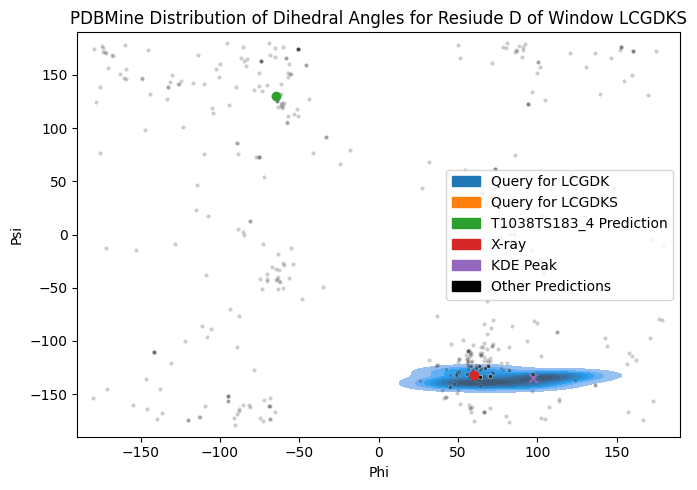

Max: P(62.67409470752088, -138.8857938718663)=0.00079565336723964


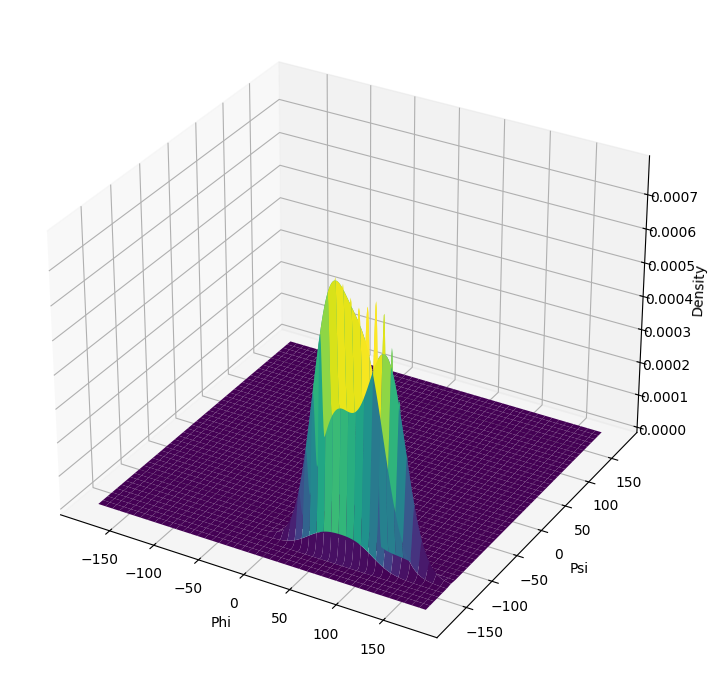

In [657]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

kdews = [1,128]
def plot_one_dist(seq, pred_id, pred_name=None, axlims=None, bw_method=None):
    pred_name = pred_name or pred_id
    inner_seq = get_subseq(seq)
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == inner_seq].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt[phi_psi_mined_ctxt.seq == seq].copy()
    phi_psi_alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == pred_id) & (phi_psi_predictions.seq_ctxt == seq)]
    xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]

    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])
    print(phi_psi_dist.groupby('weight').count().iloc[:,0].values)

    fig, ax = plt.subplots(figsize=(7,5))
    sns.scatterplot(data=phi_psi_ctxt_dist, x='phi', y='psi', ax=ax, color=colors[1],zorder=5, alpha=0.5, marker='.')
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', weights='weight', ax=ax, fill=True, color=colors[0], bw_method=bw_method)

    kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T, weights=phi_psi_dist['weight'], bw_method=bw_method)
    most_likely = phi_psi_dist.iloc[kernel(phi_psi_dist[['phi', 'psi']].values.T).argmax()]
    
    ax.plot(phi_psi_alpha.phi, phi_psi_alpha.psi, 'o', color=colors[2], label='AlphaFold Prediction', zorder=10)
    ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color=colors[3], label='X-ray', zorder=10)
    ax.scatter(most_likely.phi, most_likely.psi, color=colors[4], marker='x', label='KDE Peak', zorder=20)
    sns.scatterplot(data=phi_psi_predictions[phi_psi_predictions.seq_ctxt == seq], x='phi', y='psi', ax=ax, color='black', zorder=5, alpha=0.2, marker='.')

    ax.legend(handles=[
        mpatches.Patch(color=colors[0], label=f'Query for {inner_seq}'),
        mpatches.Patch(color=colors[1], label=f'Query for {seq}'),
        mpatches.Patch(color=colors[2], label=f'{pred_name} Prediction'),
        mpatches.Patch(color=colors[3], label='X-ray'),
        mpatches.Patch(color=colors[4], label='KDE Peak'),
        mpatches.Patch(color='black', label='Other Predictions')
    ])
    ax.set_title(f'PDBMine Distribution of Dihedral Angles for Resiude {seq[WINDOW_SIZE_CONTEXT//2]} of Window {seq}')

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')

    if axlims:
        ax.set_xlim(axlims[0][0], axlims[0][1])
        ax.set_ylim(axlims[1][0], axlims[1][1])

    plt.tight_layout()
    plt.show()

def plot_one_dist_3d(seq, pred_id, pred_name=None, bw_method=None):
    inner_seq = get_subseq(seq)#seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE // 2:WINDOW_SIZE_CONTEXT // 2 + WINDOW_SIZE // 2 + 1]
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == inner_seq].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt[phi_psi_mined_ctxt.seq == seq].copy()

    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])

    x = phi_psi_dist[['phi','psi']].values.T
    weights = phi_psi_dist['weight'].values
    kde = gaussian_kde(x, weights=weights, bw_method=bw_method)

    x_grid, y_grid = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(-180, 180, 360))
    grid = np.vstack([x_grid.ravel(), y_grid.ravel()])
    z = kde(grid).reshape(x_grid.shape)
    print(f'Max: P({grid[0,z.argmax()]}, {grid[1,z.argmax()]})={z.max()}')

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, z, cmap='viridis')
    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')
    ax.set_zlabel('Density')
    plt.tight_layout()
    plt.show()

# seq = overlapping_seqs[29]
# seq = overlapping_seqs[32]
# seq = overlapping_seqs[36]
# seq = overlapping_seqs[37]
# seq = overlapping_seqs[74]
seq = overlapping_seqs[100] # both accurate T1030
# seq = 'LCGDKS' # T1038,  protein_ids[5] # bad pred, good xray
# seq = seqs[16]
bw_method = None
# plot_one_dist(seq, alphafold_id, 'AlphaFold', axlims=((-180, 180), (-180, 180)), bw_method=bw_method)
plot_one_dist(seq, protein_ids[0], '', bw_method=bw_method, axlims=((-190, 190), (-190, 190)))
plot_one_dist_3d(seq, protein_ids[0], '', bw_method=bw_method)

In [492]:
def find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews):
    # combine with weights
    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])

    # Cluster with DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=3).fit(phi_psi_dist.values)
    phi_psi_dist['cluster'] = clustering.labels_

    # Find most probable cluster
    kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T, weights=phi_psi_dist['weight'], bw_method=bw_method)
    most_likely = phi_psi_dist.iloc[kernel(phi_psi_dist[['phi', 'psi']].values.T).argmax()]
    phi_psi_dist['prob'] = kernel(phi_psi_dist[['phi', 'psi']].values.T)
    c = phi_psi_dist[phi_psi_dist.cluster != -1].groupby('cluster').sum(numeric_only=True)
    if c.shape[0] == 0:
        print('No clusters found, using entire dist')
        phi_psi_dist_c = phi_psi_dist
    else:
        phi_psi_dist_c = phi_psi_dist[phi_psi_dist.cluster == c.prob.idxmax()]

    if phi_psi_dist_c.shape[0] < 3:
        print('Too few points in cluster - using entire dist')
        phi_psi_dist_c = phi_psi_dist

    print('Chosen dist:', phi_psi_dist_c.shape, phi_psi_dist_c.phi.mean(), phi_psi_dist_c.psi.mean())
    return phi_psi_dist, phi_psi_dist_c, most_likely

# kmeans
def find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews):
    # combine with weights
    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])

    # Find probability of each point
    kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T, weights=phi_psi_dist['weight'], bw_method=bw_method)
    most_likely = phi_psi_dist.iloc[kernel(phi_psi_dist[['phi', 'psi']].values.T).argmax()]
    phi_psi_dist['prob'] = kernel(phi_psi_dist[['phi', 'psi']].values.T)

    # cluster with kmeans
    max_sil_avg = -1
    for k in range(2, min(phi_psi_dist.shape[0], 7)):
        kmeans = KMeans(n_clusters=k)
        labels = kmeans.fit_predict(phi_psi_dist[['phi', 'psi']])
        sil_avg = silhouette_score(phi_psi_dist[['phi', 'psi']], labels)
        if sil_avg > max_sil_avg:
            max_sil_avg = sil_avg
            phi_psi_dist['cluster'] = labels
    
    # Find most probable cluster
    c = phi_psi_dist.groupby('cluster').sum(numeric_only=True)
    phi_psi_dist_c = phi_psi_dist[phi_psi_dist.cluster == c.prob.idxmax()]
    if phi_psi_dist_c.shape[0] < 3:
        print('Too few points in cluster - using entire dist')
        phi_psi_dist_c = phi_psi_dist

    print('Chosen dist:', phi_psi_dist_c[['phi', 'psi']].shape, phi_psi_dist.phi.mean(), phi_psi_dist.psi.mean())    
    return phi_psi_dist, phi_psi_dist_c, most_likely

# X-means
# def find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews):
#     pass


def calc_maha_for_one(phi_psi: np.ndarray, phi_psi_dist: np.ndarray, kdepeak):    
    cov = np.cov(phi_psi_dist.T)
    if np.diag(cov).min() < 1:
        print('No significant variance in distribution - using distance to kde peak')
        return np.sqrt((phi_psi[0] - kdepeak[0])**2 + (phi_psi[1] - kdepeak[1])**2)
    if np.linalg.det(cov) == 0:
        print('Singular covariance matrix - using distance to kde peak')
        return np.sqrt((phi_psi[0] - kdepeak[0])**2 + (phi_psi[1] - kdepeak[1])**2)
    
    icov = np.linalg.inv(cov)
    mean = phi_psi_dist.mean(axis=0)
    return np.sqrt((phi_psi - mean) @ icov @ (phi_psi - mean).T)

def calc_maha(phi_psi_preds, phi_psi_dist, kdepeak):
    cov = np.cov(phi_psi_dist.T)
    if np.diag(cov).min() < 1:
        print('No significant variance in distribution - using distance to kde peak')
        return np.sqrt(((phi_psi_preds[:,0] - kdepeak[0])**2) + ((phi_psi_preds[:,1] - kdepeak[1])**2))
    if np.linalg.det(cov) == 0:
        print('Singular covariance matrix - using distance to kde peak')
        return np.sqrt(((phi_psi_preds[:,0] - kdepeak[0])**2) + ((phi_psi_preds[:,1] - kdepeak[1])**2))
    
    icov = np.linalg.inv(cov)
    diff = phi_psi_preds - phi_psi_dist.mean(axis=0)
    return np.sqrt((np.expand_dims((diff), 1) @ icov @ np.expand_dims((diff), 2)).squeeze())

Chosen dist: (43, 2) -89.98157894736842 70.62456140350876
{0: 71, 1: 43}


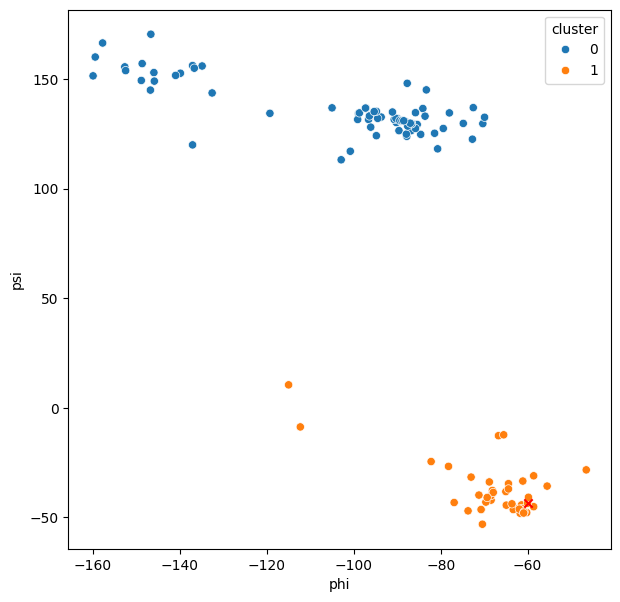

In [496]:
eps = -1
bw_method = None
seq = overlapping_seqs[100]
# seq = seqs[100]
inner_seq = get_subseq(seq)
phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']].copy()
phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']].copy()
phi_psi_dist, phi_psi_dist_c, most_likely = find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews)
value_counts = phi_psi_dist.cluster.value_counts().sort_values(ascending=False)
print(value_counts.to_dict())
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(data=phi_psi_dist, x='phi', y='psi', hue='cluster', palette='tab10')
ax.scatter(most_likely.phi, most_likely.psi, marker='x', color='r')

IKKPG (39, 2)
IKKPGE (15, 2)
Chosen dist: (45, 2) -73.49074074074075 130.9925925925926
xray: 3.3207439895284536
alpha: 5.551628117419688
preds:
                 0
count  444.000000
mean     6.412835
std      5.159298
min      0.339032
25%      2.686401
50%      5.216344
75%      8.735136
max     30.461457
{0: 45, 1: 9}


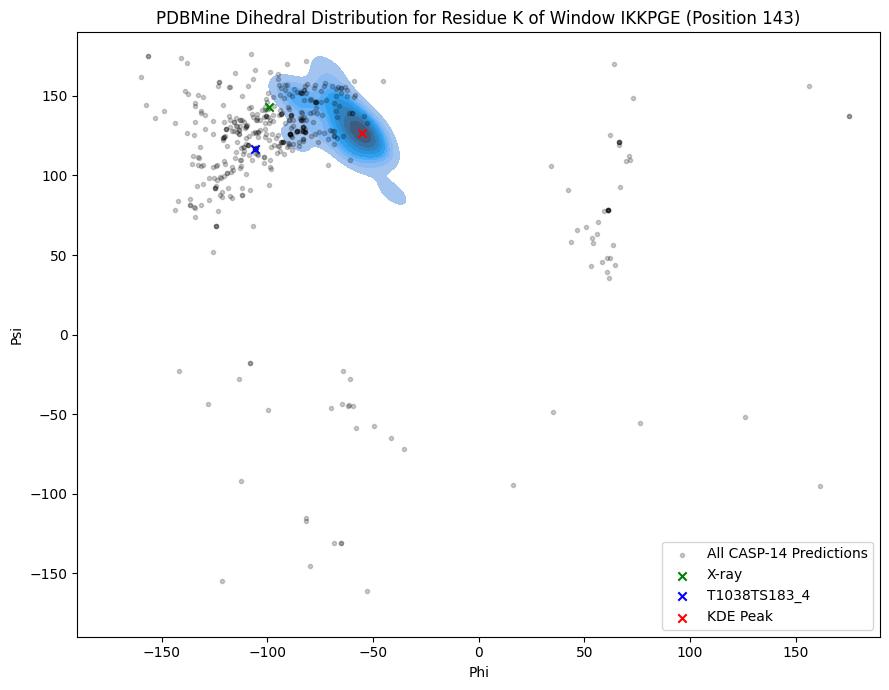

In [659]:
# For one window
def plot_clusters_for_window(seq, pred_id, pred_name=None, eps=10, bw_method=0.1, kdews=None, axlims=None, zoom=False, zoom_lims=None):
    inner_seq = get_subseq(seq)
    kdews = kdews or [1,128]
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']].copy()
    xray = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]
    alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == pred_id) & (phi_psi_predictions.seq_ctxt == seq)]
    preds = phi_psi_predictions[phi_psi_predictions.seq_ctxt == seq]

    if xray.shape[0] == 0:
        print('No xray data for this window')
        return
    if alpha.shape[0] == 0:
        print('No alpha data for this window')
        return
    if preds.shape[0] == 0:
        print('No predictions for this window')
        return
    
    pos = xray['pos'].values[0]

    print(inner_seq, phi_psi_dist.shape)
    print(seq, phi_psi_ctxt_dist.shape)

    phi_psi_dist, phi_psi_dist_c, most_likely = find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews)

    # Mahalanobis distance to most common cluster
    md_xray = calc_maha_for_one(xray[['phi','psi']].values[0], phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)
    md_alpha = calc_maha_for_one(alpha[['phi','psi']].values[0], phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)
    md_preds = calc_maha(preds[['phi','psi']].values, phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)

    print('xray:', md_xray)
    print('alpha:', md_alpha)
    print('preds:\n', pd.DataFrame(md_preds).describe())
    value_counts = phi_psi_dist.cluster.value_counts().sort_values(ascending=False)
    print(value_counts.to_dict())

    fig, ax = plt.subplots(figsize=(9,7))
    sns.kdeplot(data=phi_psi_dist_c, x='phi', y='psi', ax=ax, legend=False, fill=True)
    # ax.scatter(phi_psi_ctxt_dist.phi, phi_psi_ctxt_dist.psi, color='orange', marker='.', label=f'{seq} Query')
    ax.scatter(preds.phi, preds.psi, color='black', marker='.', alpha=0.2, label='All CASP-14 Predictions')
    ax.scatter(xray.phi, xray.psi, color='green', marker='x', label='X-ray')
    ax.scatter(alpha.phi, alpha.psi, color='blue', marker='x', label=pred_name)
    ax.scatter(most_likely.phi, most_likely.psi, color='red', marker='x', label='KDE Peak')

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')
    res = phi_psi_predictions.loc[phi_psi_predictions.seq==inner_seq, 'res'].values[0]
    ax.set_title(f'PDBMine Dihedral Distribution for Residue {res} of Window {seq} (Position {pos})')
    ax.legend()
    if axlims:
        ax.set_xlim(axlims[0][0], axlims[0][1])
        ax.set_ylim(axlims[1][0], axlims[1][1])
    plt.tight_layout()
    plt.show()
seq = overlapping_seqs[100]
# seq = seqs[1]
plot_clusters_for_window(seq, protein_ids[5], '', eps=-1, bw_method=None, axlims=((-190, 190), (-190, 190)))

In [622]:
def pre_md_filter():
    # remove sequences missing phi and psi
    global xray_phi_psi, phi_psi_predictions
    xray_phi_psi = xray_phi_psi[~xray_phi_psi.phi.isna() & ~xray_phi_psi.psi.isna()]
    # remove all predictions with outlier overlapping sequences with xray
    xray_seqs_unique = set(xray_phi_psi.seq_ctxt.unique())
    grouped = phi_psi_predictions.groupby('protein_id').agg(
        overlapping_seqs=('seq_ctxt', lambda series: len(set(series.unique()) & xray_seqs_unique)),
        length=('seq_ctxt', 'count')
    )
    overlapping_seqs = grouped.overlapping_seqs[grouped.overlapping_seqs == grouped.overlapping_seqs.mode().values[0]]
    lengths = grouped.length[grouped.length == grouped.length.mode().values[0]]
    phi_psi_predictions = phi_psi_predictions[(phi_psi_predictions.protein_id.isin(overlapping_seqs.index)) & (phi_psi_predictions.protein_id.isin(lengths.index))]

def get_md_for_all_predictions(eps=10, bw_method=None, kdews=None):
    kdews = kdews or [1,128]
    phi_psi_predictions['md'] = np.nan
    xray_phi_psi['md'] = np.nan
    for i,seq in enumerate(xray_phi_psi.seq_ctxt.unique()):
        inner_seq = get_subseq(seq)
        phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']]
        phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']]
        print(f'{seq}: {phi_psi_dist.shape[0]} {phi_psi_ctxt_dist.shape[0]}')

        if phi_psi_ctxt_dist.shape[0] > 2:
            print('Enough context data for KDE - Using Full Context')
        if phi_psi_dist.shape[0] <= 2:
            print(f'Skipping {seq} - not enough data points')
            # leave as nan
            continue

        phi_psi_dist, phi_psi_dist_c, most_likely = find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews)

        # Mahalanobis distance to most common cluster
        xray = xray_phi_psi[xray_phi_psi.seq_ctxt == seq][['phi','psi']]
        if xray.shape[0] == 0:
            print(f'No xray seq {seq}')
        else:
            md_xray = calc_maha_for_one(xray[['phi','psi']].values[0], phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)
            xray_phi_psi.loc[xray_phi_psi.seq_ctxt == seq, 'md'] = md_xray
            
        preds = phi_psi_predictions.loc[phi_psi_predictions.seq_ctxt == seq][['phi','psi']]
        if preds.shape[0] == 0:
            print(f'No predictions seq {seq}')
        else:
            md = calc_maha(preds[['phi','psi']].values, phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)
            phi_psi_predictions.loc[phi_psi_predictions.seq_ctxt == seq, 'md'] = md
        print(xray.shape, preds.shape, phi_psi_dist.shape, phi_psi_ctxt_dist.shape)

    # phi_psi_predictions.to_csv(outdir / f'phi_psi_predictions_md-eps{eps}.csv', index=False)
    # xray_phi_psi.to_csv(outdir / f'xray_phi_psi_md-eps{eps}.csv', index=False)
    phi_psi_predictions.to_csv(outdir / f'phi_psi_predictions_md-kmeans.csv', index=False)
    xray_phi_psi.to_csv(outdir / f'xray_phi_psi_md-kmeans.csv', index=False)

eps=-1
bw_method=None
kdews=[1,128]
pre_md_filter()
get_md_for_all_predictions(eps, bw_method, kdews)

VPGDMV: 36 2
Chosen dist: (20, 2) -64.66842105263157 -16.381578947368425
(1, 2) (184, 2) (38, 5) (2, 3)
PGDMVR: 51 2
Chosen dist: (50, 2) -84.76037735849057 156.1754716981132
(1, 2) (184, 2) (53, 5) (2, 3)
GDMVRI: 66 2
Chosen dist: (44, 2) -90.20735294117647 64.50882352941176
(1, 2) (184, 2) (68, 5) (2, 3)
DMVRIP: 52 2
Chosen dist: (19, 2) -75.02407407407408 24.618518518518524
(1, 2) (184, 2) (54, 5) (2, 3)
MVRIPG: 20 2
Chosen dist: (4, 2) -111.47727272727275 137.96363636363634
(1, 2) (184, 2) (22, 5) (2, 3)
VRIPGG: 48 2
Chosen dist: (22, 2) -104.79000000000002 134.516
(1, 2) (184, 2) (50, 5) (2, 3)
RIPGGT: 34 2
Chosen dist: (35, 2) -68.50833333333333 148.9472222222222
(1, 2) (184, 2) (36, 5) (2, 3)
IPGGTF: 236 13
Enough context data for KDE - Using Full Context
Chosen dist: (13, 2) -53.4004016064257 17.99839357429719
(1, 2) (184, 2) (249, 5) (13, 3)
PGGTFL: 70 4
Enough context data for KDE - Using Full Context
Chosen dist: (29, 2) 35.98513513513514 -41.2027027027027
(1, 2) (184, 2) (7

In [110]:
# eps=5
# phi_psi_predictions = pd.read_csv(outdir / f'phi_psi_predictions_md-eps{eps}.csv')
# xray_phi_psi = pd.read_csv(outdir / f'xray_phi_psi_md-eps{eps}.csv')
phi_psi_predictions = pd.read_csv(outdir / f'phi_psi_predictions_md-kmeans.csv')
xray_phi_psi = pd.read_csv(outdir / f'xray_phi_psi_md-kmeans.csv')

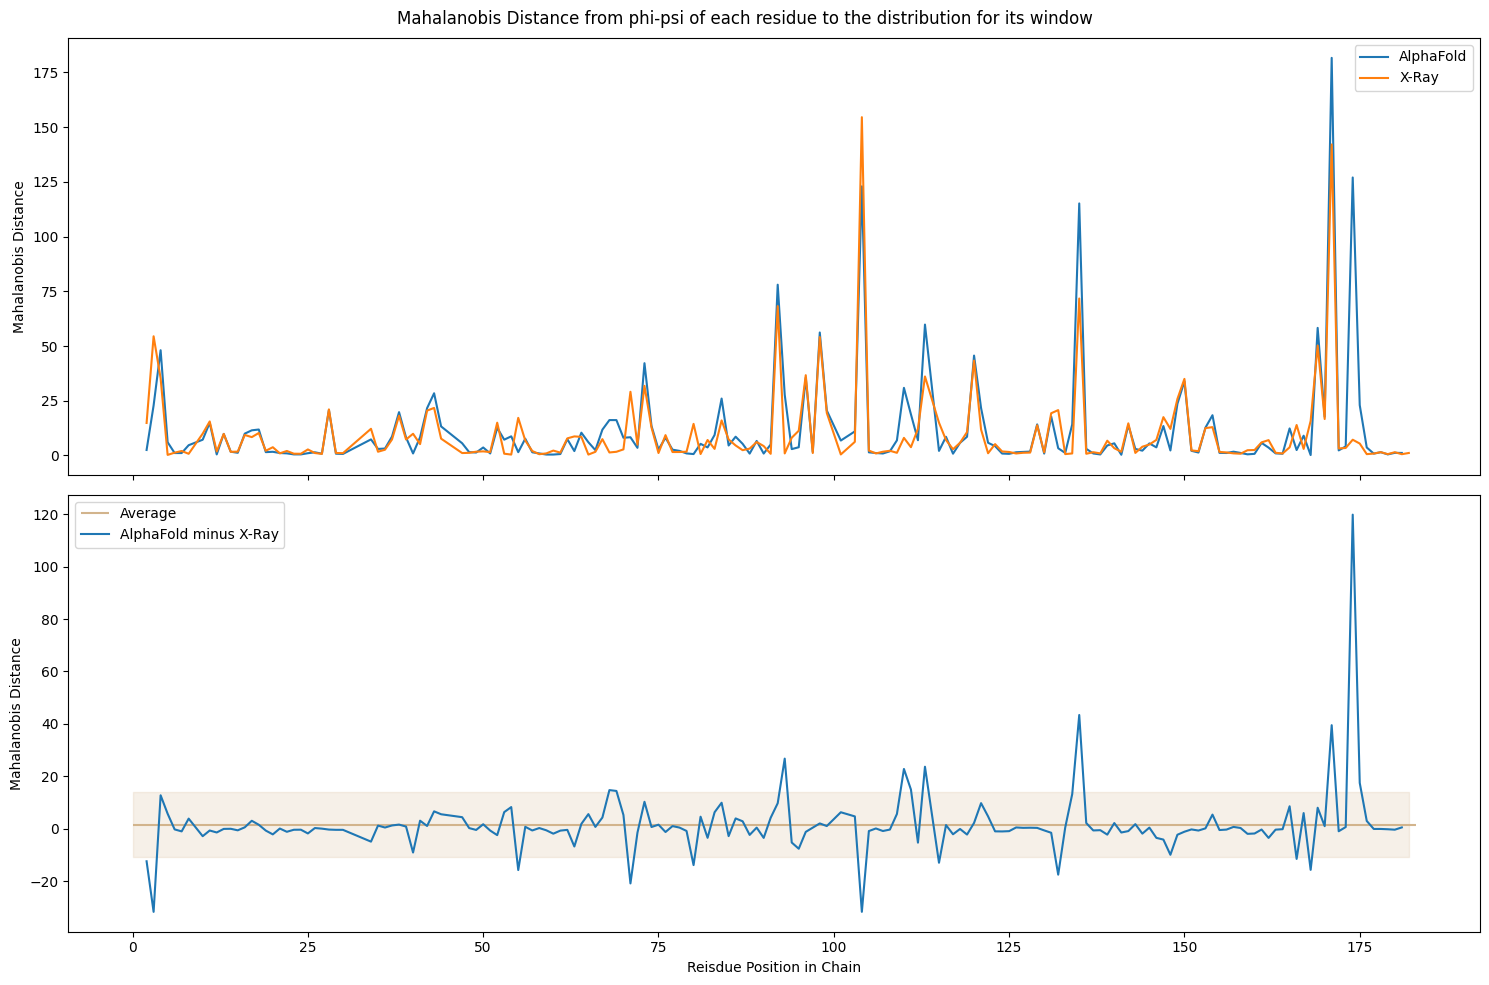

In [10]:
# Plot xray vs prediction md for each residue of one prediction
def plot_res_vs_md(pred_id, pred_name=None, highlight_res=None, limit_quantile=None):
    pred_name = pred_name or pred_id
    phi_psi_predictions['Source'] = 'CASP Prediction'
    phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id, 'Source'] = pred_name
    alpha = phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id]
    xray_phi_psi['Source'] = 'X-Ray'
    both = pd.merge(alpha, xray_phi_psi[['seq', 'md']], how='inner', on=['seq','seq'], suffixes=('_alpha','_xray'))
    both['md_diff'] = both['md_alpha'] - both['md_xray']
    fig, axes = plt.subplots(2, figsize=(15,10), sharex=True)
    both_limit = both.copy()
    if limit_quantile:
        both_limit[both_limit.md_alpha > both_limit.md_alpha.quantile(limit_quantile)] = np.nan
        both_limit[both_limit.md_xray > both_limit.md_xray.quantile(limit_quantile)] = np.nan
        both_limit[both_limit.md_diff > both_limit.md_diff.quantile(limit_quantile)] = np.nan
    sns.lineplot(data=both_limit.reset_index(), x='index', y='md_alpha', ax=axes[0], label=pred_name)
    sns.lineplot(data=both_limit.reset_index(), x='index', y='md_xray', ax=axes[0], label='X-Ray')
    axes[0].set_ylabel('Mahalanobis Distance')
    axes[1].hlines(both_limit['md_diff'].mean(), xmin=0, xmax=len(both_limit), color='tan', label='Average')
    axes[1].fill_between(x=both_limit.index, y1=both_limit['md_diff'].mean() + both_limit['md_diff'].std(), y2=both_limit['md_diff'].mean() - both_limit['md_diff'].std(), color='tan', alpha=0.2)
    sns.lineplot(data=both_limit.reset_index(), x='index', y='md_diff', ax=axes[1], label=f'{pred_name} minus X-Ray')
    axes[1].set_ylabel('Mahalanobis Distance')
    axes[1].set_xlabel('Reisdue Position in Chain')
    fig.suptitle('Mahalanobis Distance from phi-psi of each residue to the distribution for its window')
    plt.tight_layout()

    if highlight_res:
        for ax in axes:
            ax.axvspan(highlight_res[0], highlight_res[1], color='red', alpha=0.2)
    
    return both

protein_ids = phi_psi_predictions.protein_id.unique()
# both = plot_res_vs_md(protein_ids[5], pred_name="AlphaFold") # 1030
# both = plot_res_vs_md(protein_ids[8], pred_name="AlphaFold") # 1038
# both = plot_res_vs_md(protein_ids[3], pred_name="AlphaFold") # 1024
both = plot_res_vs_md(protein_ids[6], pred_name="AlphaFold") 
# NOTE: for presentation, highlight area around res-300 to show this is where alphafold did bad

R-squared: 0.979089


/tmp/ipykernel_3233157/3269193349.py:32: RuntimeWarning: Mean of empty slice
  X = np.where(np.isnan(X), np.nanmean(X,axis=0), X)


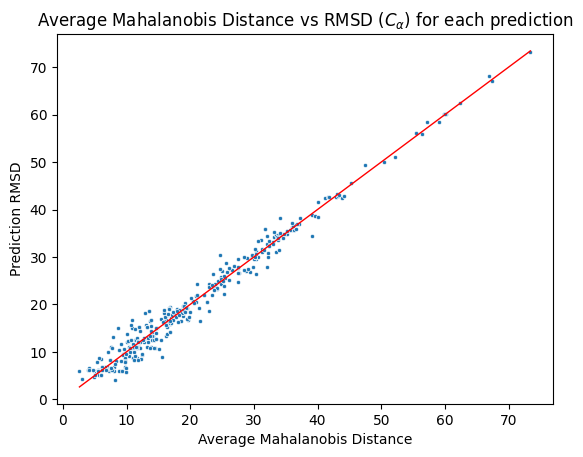

In [111]:
# Compare rmsd and mahalanobis distance
import matplotlib.pyplot as plt
from scipy.stats import linregress

def filter_and_agg(series, agg='sum', quantile=0.8):
    series = series[series < series.quantile(quantile)]
    return series.agg(agg)

def calc_perc_na(series):
    return series.sum() / len(series)

def plot_md_vs_rmsd(rmsd_lim_low=0, rmsd_lim_high=np.inf, md_lim_low=0, md_lim_high=np.inf):
    phi_psi_predictions['md_na'] = phi_psi_predictions.md.isna()
    group_maha = phi_psi_predictions.groupby('protein_id', as_index=False).agg(
        md=('md',lambda x: filter_and_agg(x, agg='sum', quantile=1)), 
        std_md=('md',lambda x: filter_and_agg(x, agg='std', quantile=1)), 
        md_na=('md_na',calc_perc_na),
        mds=('md', list)
    )
    group_maha = group_maha.merge(results[['Model', 'RMS_CA']], left_on='protein_id', right_on='Model', how='inner')
    
    group_maha = group_maha[group_maha.md_na <= group_maha.md_na.quantile(.9)]
    group_maha = group_maha[
        (group_maha.RMS_CA > rmsd_lim_low) & \
        (group_maha.RMS_CA < rmsd_lim_high) & \
        (group_maha.md > md_lim_low) &\
        (group_maha.md < md_lim_high)
    ].dropna()

    X = np.array(group_maha.mds.values.tolist())
    y = group_maha.RMS_CA.values
    X = np.where(np.isnan(X), np.nanmean(X,axis=0), X)
    X[np.isnan(X)] = 0
    regr = LinearRegression().fit(X, y)
    rsquared = regr.score(X, y)
    group_maha['rms_pred'] = regr.predict(X)

    fig, ax = plt.subplots()
    sns.scatterplot(data=group_maha, x='rms_pred', y='RMS_CA', ax=ax, marker='.', legend=False)
    sns.regplot(data=group_maha, x='rms_pred', y='RMS_CA', ax=ax, ci=False, scatter=False, color='red', line_kws={'lw':1}, label='Regression Line')
    ax.set_xlabel('Average Mahalanobis Distance')
    ax.set_ylabel('Prediction RMSD')
    ax.set_title(r'Average Mahalanobis Distance vs RMSD ($C_{\alpha}$) for each prediction')
    print(f"R-squared: {rsquared:.6f}")
    return group_maha
group_maha = plot_md_vs_rmsd(0,90, 0, 5000)
# ax.set_xlim((0.8,1.4))
# ax.set_ylim((0,6))

/tmp/ipykernel_3233157/1405708642.py:4: RuntimeWarning: Mean of empty slice
  X = np.where(np.isnan(X), np.nanmean(X,axis=0), X)


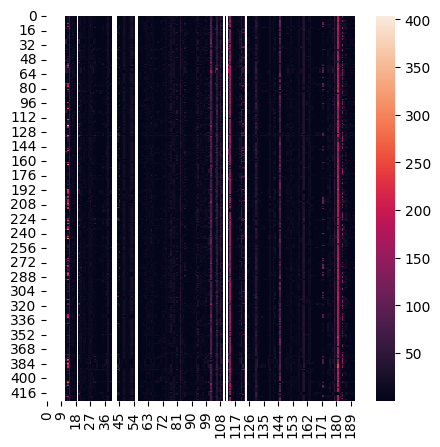

In [26]:
def plot_heat_map():
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    X = np.array(group_maha.mds.values.tolist())
    X = np.where(np.isnan(X), np.nanmean(X,axis=0), X)
    y = group_maha.RMS_CA.values.reshape(-1,1)
    # sns.heatmap(y, ax=axes[0])
    sns.heatmap(X, ax=ax)
plot_heat_map()

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pickle

X = np.array(group_maha.mds.values.tolist())
y = group_maha.RMS_CA.values

# p1 = (1000 - X.shape[1]) // 2
# p2 = 1000 - X.shape[1] - p1
# X = np.pad(X, ((0,0),(p1,p2)))

X = np.where(np.isnan(X), np.nanmean(X,axis=0), X)
X[np.isnan(X)] = 0
regr = LinearRegression().fit(X, y)
regr.score(X, y)

# pickle.dump(X, open(f'pkls/X-{casp_protein_id}.pkl', 'wb'))
# pickle.dump(y, open(f'pkls/y-{casp_protein_id}.pkl', 'wb'))

/tmp/ipykernel_3233157/4118525358.py:12: RuntimeWarning: Mean of empty slice
  X = np.where(np.isnan(X), np.nanmean(X,axis=0), X)


0.7983027888691249

In [ ]:
def plot_md_vs_rmsd_for_multiple(rmsd_lim=np.inf, md_lim_low=0, md_lim=np.inf):
    phi_psi_predictions = []
    xray_phi_psi = []
    results = []
    for protein_id in ['T1024', 'T1028', 'T1030']:
        outdir_ = Path(f'tests/{protein_id}_win5-6')
        phi_psi_predictions.append(pd.read_csv(outdir_ / f'phi_psi_predictions_md-kmeans.csv'))
        xray_phi_psi.append(pd.read_csv(outdir_ / f'xray_phi_psi_md-kmeans.csv'))
        results_file = Path(results_dir / f'{protein_id}.txt')
        if not results_file.exists():
            results_file = Path(results_dir / f'{protein_id}-D1.txt')
        results.append(pd.read_csv(results_file, sep='\s+'))
        results[-1] = results[-1][results[-1].columns[1:]]
        results[-1]['Model'] = results[-1]['Model'].apply(lambda x: x.split('-')[0])
    phi_psi_predictions = pd.concat(phi_psi_predictions)
    xray_phi_psi = pd.concat(xray_phi_psi)
    results = pd.concat(results)

    phi_psi_predictions['target'] = phi_psi_predictions.protein_id.apply(lambda x: x[:5])

    phi_psi_predictions['md_na'] = phi_psi_predictions.md.isna()
    group_maha = phi_psi_predictions.groupby('protein_id', as_index=False).agg(
        md=('md',lambda x: filter_and_agg(x, agg='sum', quantile=0.9)), 
        std_md=('md',lambda x: filter_and_agg(x, agg='std', quantile=0.8)), 
        md_na=('md_na',calc_perc_na),
        target=('target',lambda x: x.iloc[0])
    )
    group_maha = group_maha.merge(results[['Model', 'RMS_CA']], left_on='protein_id', right_on='Model', how='inner')
    group_maha = group_maha[group_maha.md_na <= group_maha.md_na.quantile(0.95)]
    group_maha = group_maha[(group_maha.RMS_CA < rmsd_lim) & (group_maha.md > md_lim_low) & (group_maha.md < md_lim)].dropna()

    # normalize md by target
    group_maha['md'] = group_maha.groupby('target')['md'].transform(lambda x: (x - x.mean()) / x.std())

    fig, ax = plt.subplots()
    sns.scatterplot(data=group_maha, x='md', y='RMS_CA', ax=ax, marker='.', legend=False)
    sns.regplot(data=group_maha, x='md', y='RMS_CA', ax=ax, ci=False, scatter=False, color='red', line_kws={'lw':1}, label='Regression Line')
    ax.set_xlabel('Average Mahalanobis Distance')
    ax.set_ylabel('Prediction RMSD')
    ax.set_title(r'Average Mahalanobis Distance vs RMSD ($C_{\alpha}$) for each prediction')
    regr = linregress(group_maha.md, group_maha.RMS_CA)
    print(f"R-squared: {regr.rvalue**2:.6f}")
    return group_maha
    
plot_md_vs_rmsd_for_multiple();

# Specific Cases

In [643]:
fig = px.scatter(group_maha, x='md', y='RMS_CA', text='protein_id')
fig.show(renderer='browser')

In [252]:
group_maha.sort_values('md', ascending=False).head()

,protein_id,md,std_md,md_na,Model,RMS_CA
98,T1030TS081_5,4885.150422,7.101205,0.097378,T1030TS081_5,60.092
418,T1030TS437_4,4525.911462,7.832499,0.097378,T1030TS437_4,60.225
440,T1030TS476_2,4443.514979,5.748981,0.097378,T1030TS476_2,34.079
417,T1030TS437_3,4314.864687,7.070658,0.097378,T1030TS437_3,60.082
369,T1030TS376_1,4017.915821,6.728196,0.097378,T1030TS376_1,31.377


(183, 13)


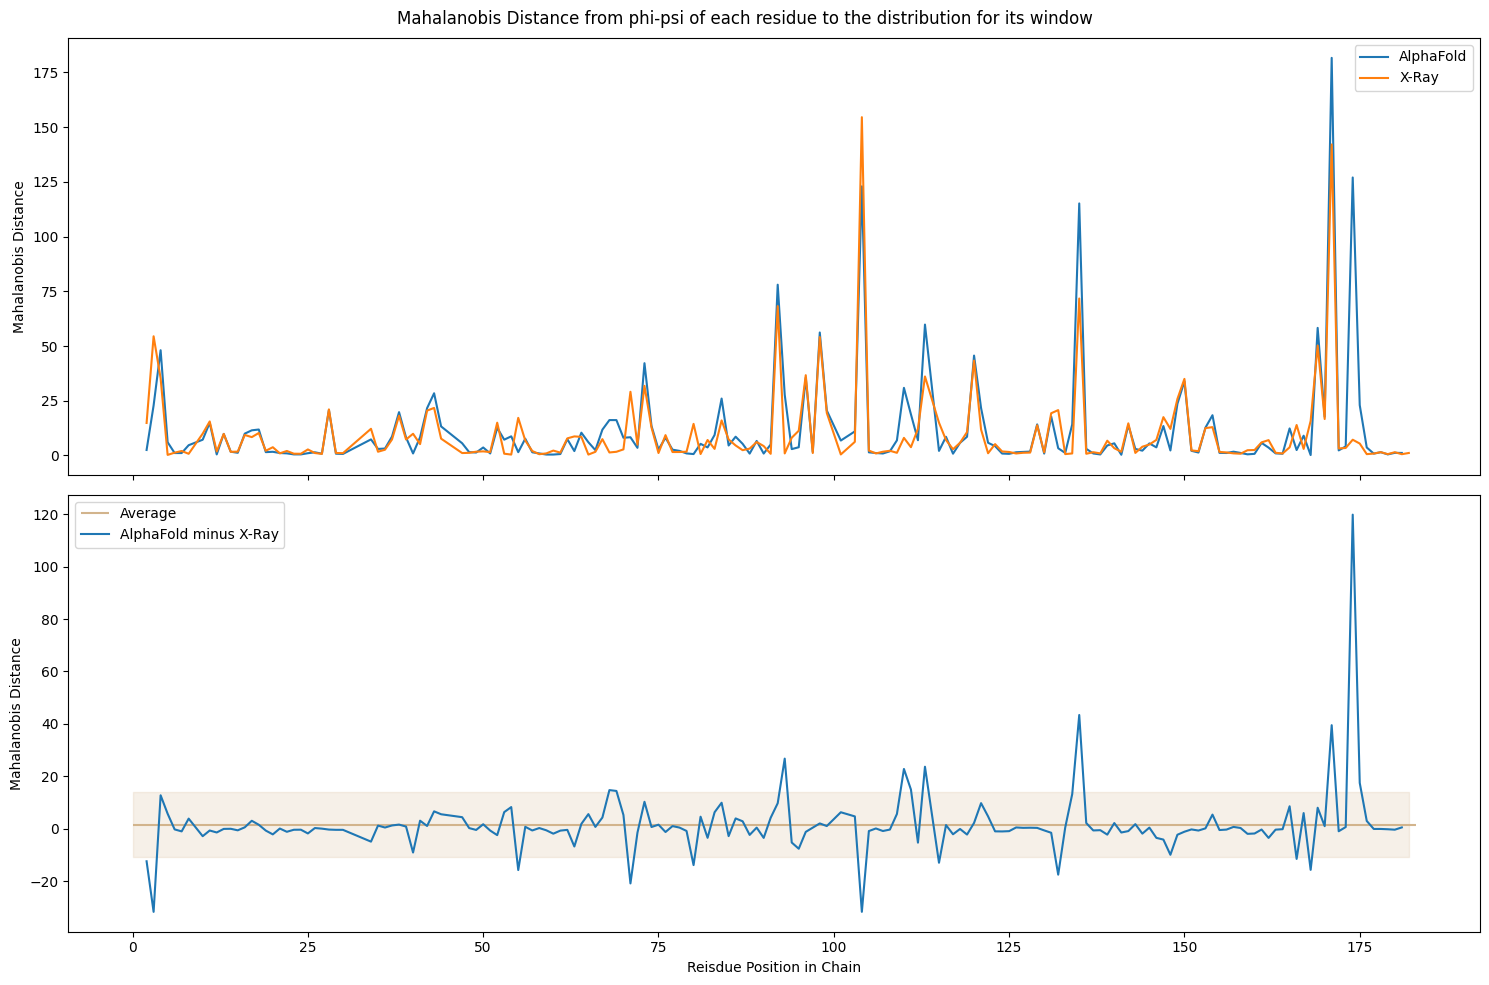

In [646]:
id = protein_ids[5]
both = plot_res_vs_md(id, pred_name="AlphaFold", limit_quantile=1)
print(both.shape)

In [644]:
fig = px.line(both.reset_index(), x='index', y=['md_alpha', 'md_xray', 'md_diff'], text='seq_ctxt')
fig.show(renderer='browser')

In [652]:
fig = px.scatter(phi_psi_predictions[phi_psi_predictions.seq_ctxt == 'LCGDKS'], x='phi', y='psi', text='seq_ctxt')
# add xray
view = xray_phi_psi[xray_phi_psi.seq_ctxt == 'LCGDKS']
fig.add_scatter(x=view.phi, y=view.psi, mode='markers', marker=dict(size=10, color='red'), name='X-ray')
view = phi_psi_predictions[(phi_psi_predictions.seq_ctxt == 'LCGDKS') & (phi_psi_predictions.protein_id == id)]
fig.add_scatter(x=view.phi, y=view.psi, mode='markers', marker=dict(size=10, color='green'), name=id)
fig.show(renderer='browser')

In [601]:
both.sort_values('md_alpha', ascending=False)

,pos,seq,seq_ctxt,res,phi,psi,chain,protein_id,md_alpha,Source,md_na,md_xray,md_diff
256,273,WMNFR,WMNFRY,N,-61.115448,144.927647,A,T1028TS487_4,362.418830,AlphaFold,False,2.312589,360.106241
13,30,FLQGS,FLQGSP,Q,-101.707225,162.091983,A,T1028TS487_4,230.420772,AlphaFold,False,206.618849,23.801923
264,281,RCAER,RCAERL,A,-116.586842,3.688248,A,T1028TS487_4,209.681952,AlphaFold,False,216.308695,-6.626743
283,300,FRCAR,FRCARD,C,-111.970415,164.058298,A,T1028TS487_4,119.638118,AlphaFold,False,119.983009,-0.344891
157,174,DTWDS,DTWDSR,W,-64.942461,-43.287669,A,T1028TS487_4,102.355472,AlphaFold,False,199.289535,-96.934063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,272,SWMNF,SWMNFR,M,-60.715451,-37.479776,A,T1028TS487_4,NaN,AlphaFold,True,NaN,NaN
257,274,MNFRY,MNFRYQ,F,-85.063164,179.892219,A,T1028TS487_4,NaN,AlphaFold,True,NaN,NaN
260,277,RYQVR,RYQVRC,Q,-65.755369,-45.219023,A,T1028TS487_4,NaN,AlphaFold,True,NaN,NaN
262,279,QVRCA,QVRCAE,R,-171.784205,160.849419,A,T1028TS487_4,NaN,AlphaFold,True,NaN,NaN


[6]


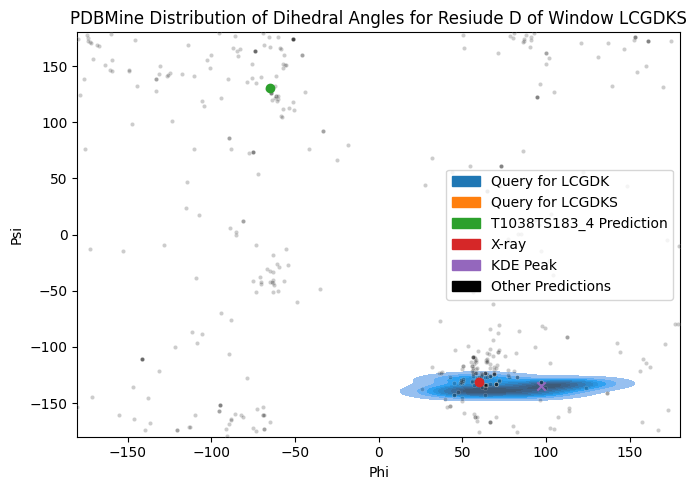

Max: P(62.67409470752088, -138.8857938718663)=0.00079565336723964


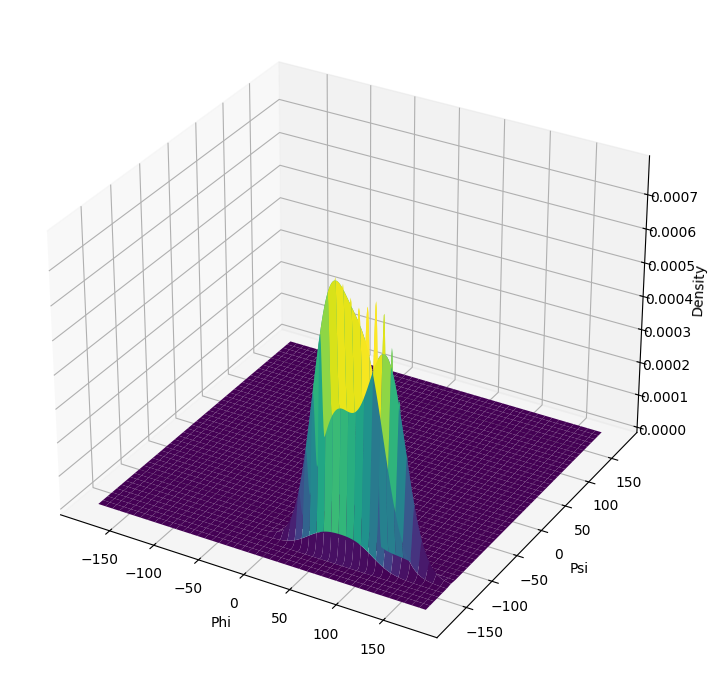

In [655]:
seq = 'LCGDKS' # T1038,  protein_ids[5]
plot_one_dist(seq, id, axlims=((-180, 180), (-180, 180)), bw_method=None)
plot_one_dist_3d(seq, id, bw_method=None)

WMNFR (23, 2)
WMNFRY (2, 2)
Chosen dist: (3, 2) 37.736 49.928000000000004
xray: 2.3125893428271613
alpha: 362.41882995987686
preds:
                  0
count   183.000000
mean    588.108979
std     569.379637
min       5.579196
25%     229.086045
50%     393.416748
75%     709.864272
max    3425.435574
{0: 21, 1: 3, 2: 1}


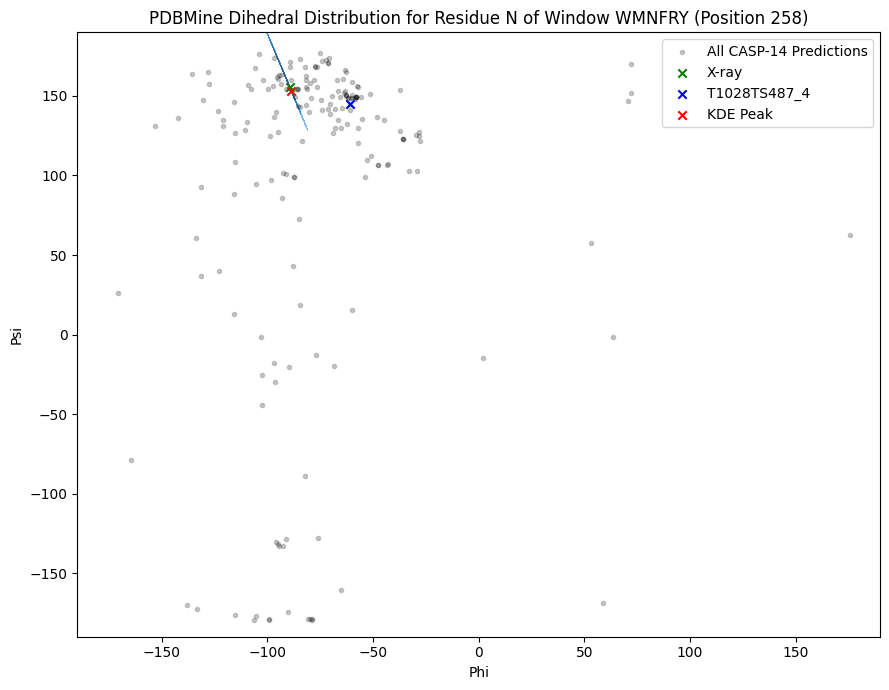

In [603]:
seq = 'WMNFRY'#both.sort_values('md_alpha', ascending=False).iloc[0].seq_ctxt_alpha
plot_clusters_for_window(seq, id, eps=15, bw_method=None, axlims=((-190, 190), (-190, 190)))